# 3.1 Modèle sous XGBoost

## Préparation

Importation des librairies

In [18]:
import matplotlib.pyplot as plt, seaborn as sns, numpy as np, pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve, mean_absolute_error, mean_squared_error, f1_score
from xgboost import XGBClassifier, plot_importance

Importation du dataset

In [19]:
df = pd.read_pickle('./Datasets/complete_dataset_with_scaling.pkl')

Séparation en jeu de train et test

In [20]:
X = df.drop('Attrition', axis=1)
y = df['Attrition']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Suppression des variables trop corrélées [jugé non nécessaire après tests]

In [21]:
# Drop dummy variables that show too much correlation (they basically mean the same thing, such as "EducationField_Marketing" and "Department_Sales")
# Redo the correlation

# Do a triangle correlation so we do not have duplicates
#corr = X_train.corr()
#triangle_mask = np.triu(np.ones_like(corr, dtype=bool))

# Get the correlation values
#new_correlation = corr.mask(triangle_mask).stack().reset_index()

# Rename the columns
#new_correlation.columns = ['Variable 1', 'Variable 2', 'Taux de correlation']

# Drop NA Corr if there are
#new_correlation.dropna(subset = ["Taux de correlation"], inplace=True)

# Round up the values and set them to absolute
#new_correlation['Taux de correlation'] = new_correlation['Taux de correlation'].round(2)
#new_correlation['Taux de correlation'] = new_correlation['Taux de correlation'].abs()

# Sort the correlations by descending order
#new_correlation.sort_values(by='Taux de correlation', ascending=False, inplace=True)

# Get the list of unique variables sin the "Variable 2" column where correlation >= 0.1
#unique_variables = new_correlation[new_correlation['Taux de correlation'] >= 0.1]['Variable 2'].unique()
#X_train = X_train.drop(columns=unique_variables)
#X_test = X_test.drop(columns=unique_variables)

Matrice de corrélation

In [22]:
# Fonction de génération de graphiques de corrélation
def plot_correlation_map( df, Size=25 ):
    corr = df.corr()
    _ , ax = plt.subplots( figsize =( Size , Size ) )
    triangle_mask = np.triu(np.ones_like(corr, dtype=bool))
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr,
        cmap = cmap,
        square=True,
        cbar_kws={ 'shrink' : .9 },
        ax=ax,
        mask=triangle_mask,
        annot = True,
        annot_kws = { 'fontsize' : 12 }
    )

C:\Users\spata\AppData\Local\Temp\ipykernel_12220\2813100603.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


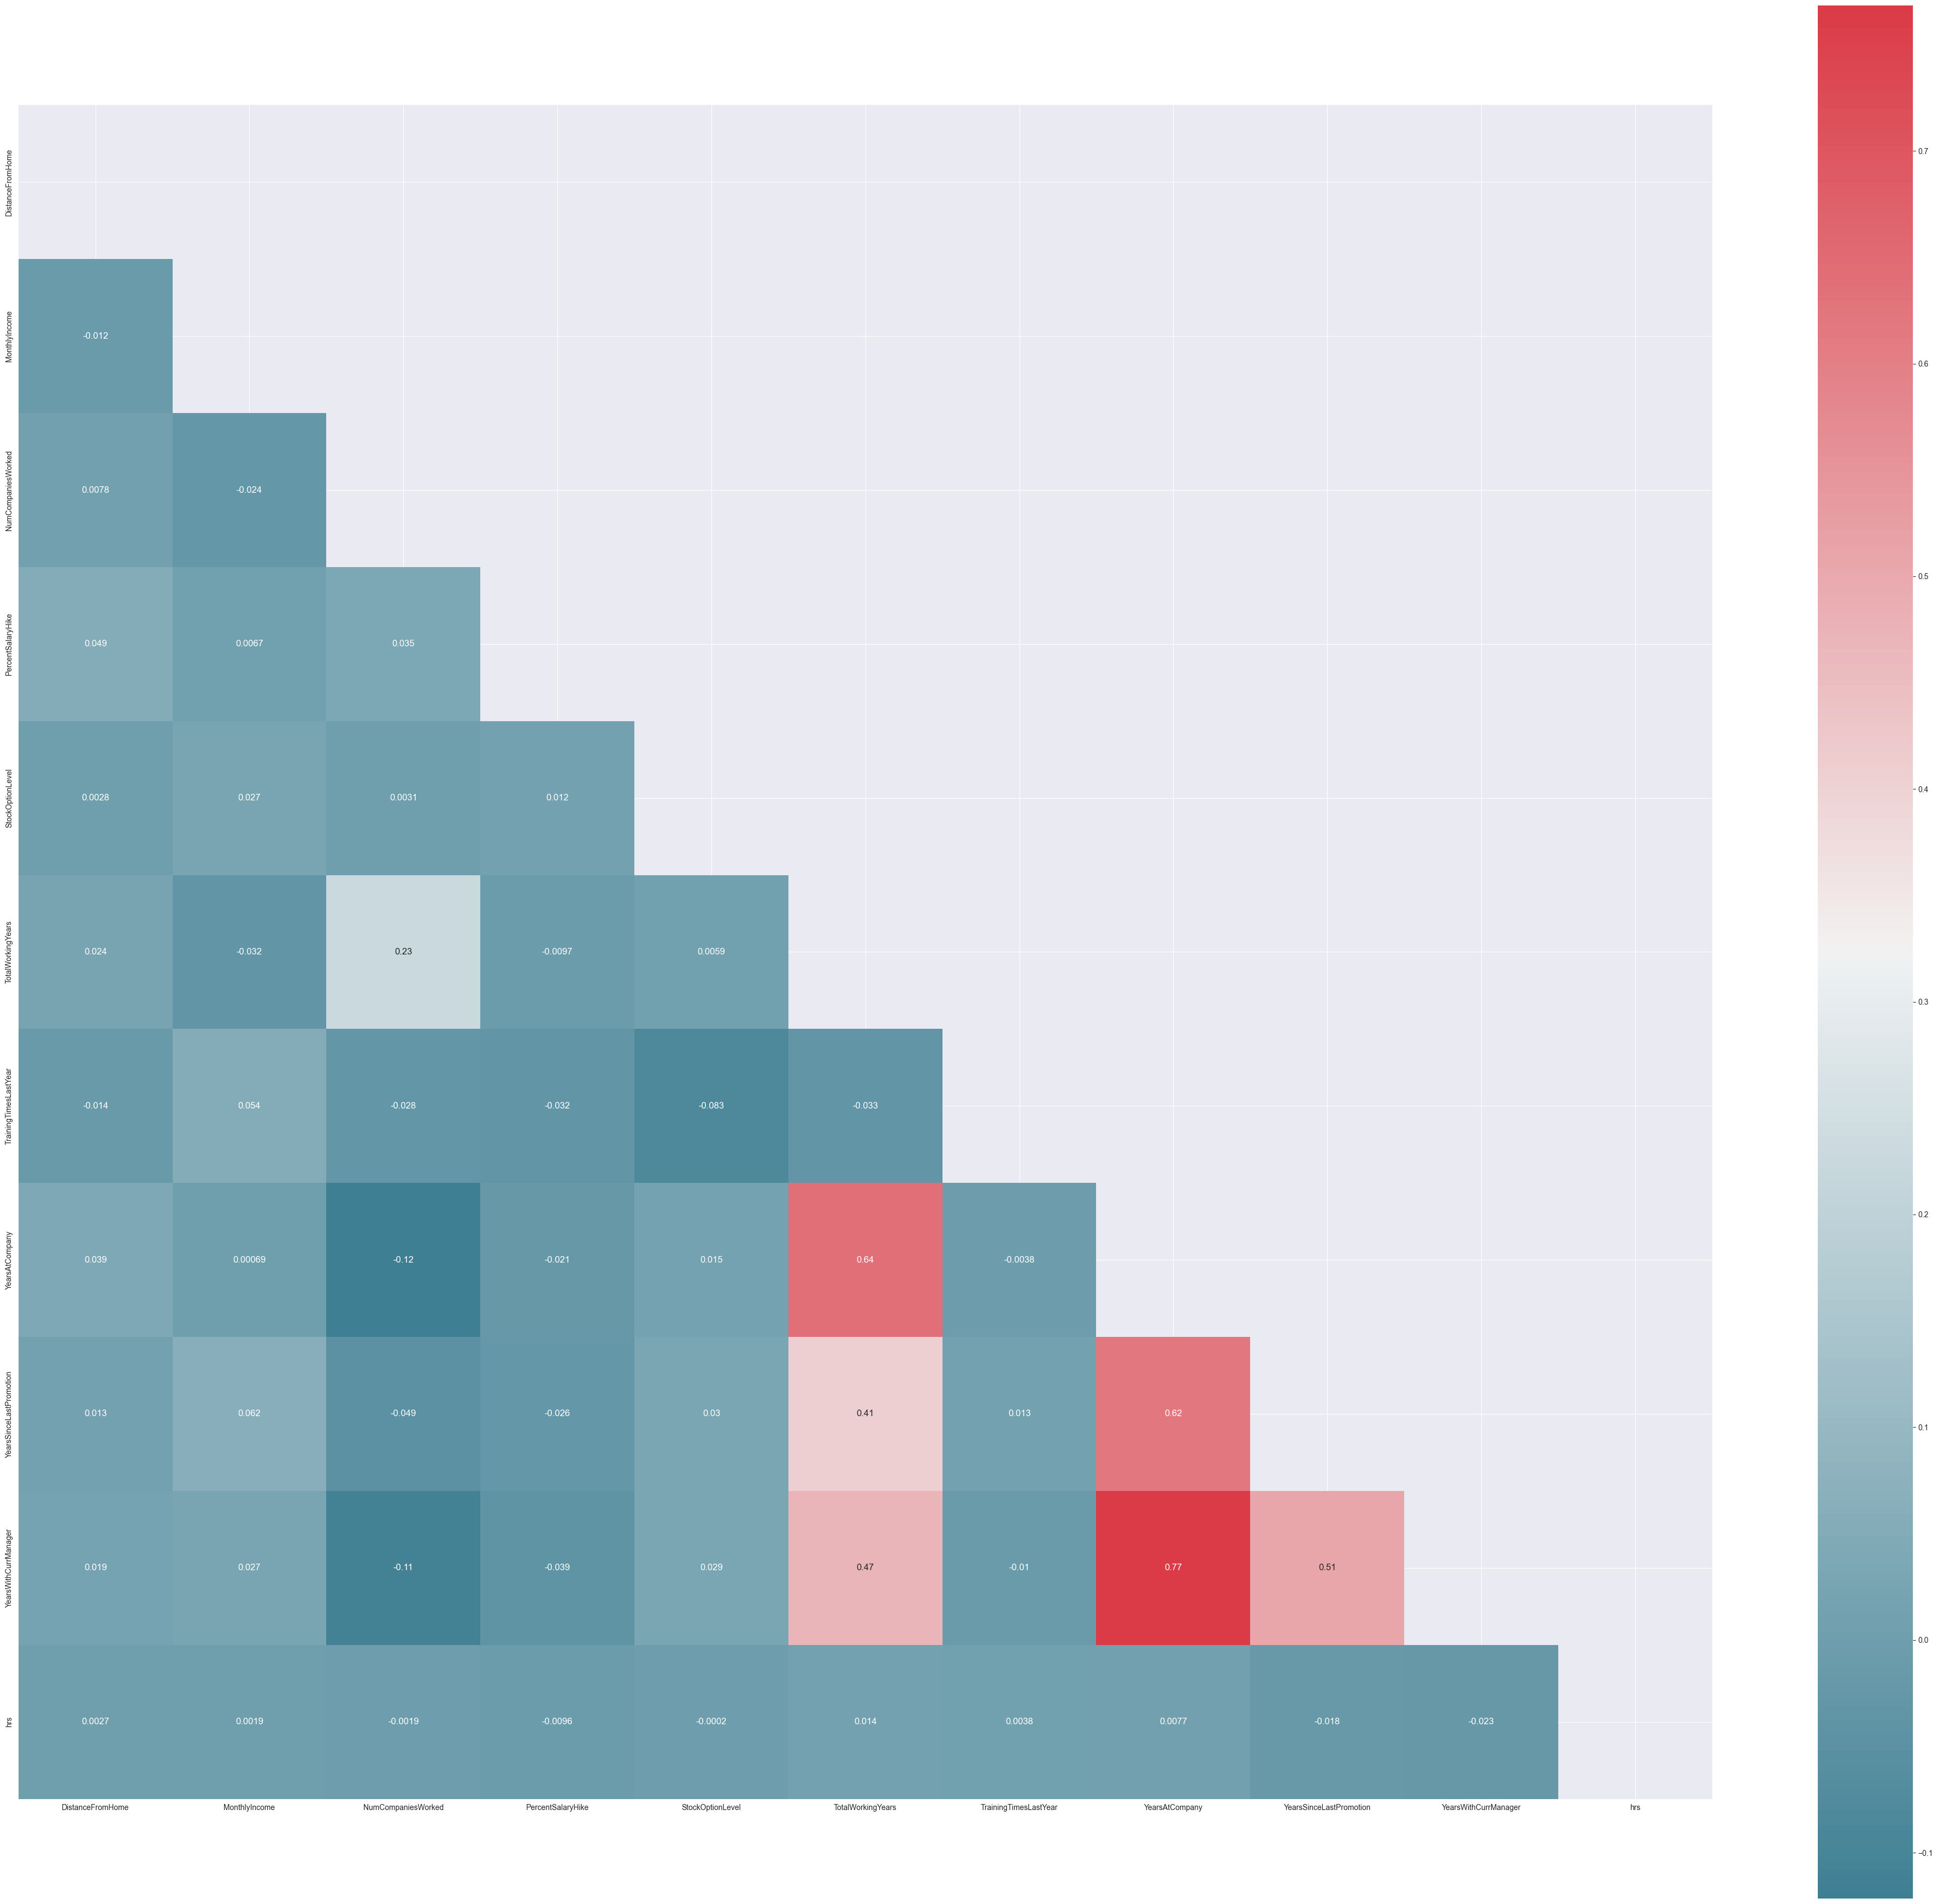

In [23]:
# Plot the matrix
plot_correlation_map(X_train,50)

Vérification de la forme des sets

In [24]:
X_train

,BusinessTravel,Department,DistanceFromHome,Education,EducationField,JobLevel,JobRole,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,...,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,hrs,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance
655,Travel_Rarely,Human Resources,0.347126,BAC+3,Human Resources,2,Laboratory Technician,-0.466801,-0.277692,-1.150723,...,0.156362,2.776278,-0.368619,1.928457,1.473305,Importante,Excellent,Faible,Moyen,Très satisfaisant
4338,Travel_Rarely,Research & Development,0.223671,BAC+3,Life Sciences,2,Sales Executive,0.106618,-0.678721,1.309108,...,-0.619989,2.122844,2.114561,1.367694,-1.113891,Importante,Au delà des attentes,Très élevé,Élevé,Très satisfaisant
3218,Travel_Rarely,Research & Development,-0.146696,BAC+2,Life Sciences,5,Laboratory Technician,-0.249458,2.128485,1.309108,...,0.156362,-0.817607,-0.058222,-0.594976,-0.405734,Très importante,Au delà des attentes,Faible,Faible,Très satisfaisant
4210,Travel_Rarely,Sales,0.100215,BAC+2,Life Sciences,2,Research Scientist,1.007217,0.123338,-0.877408,...,0.156362,-0.000815,-0.368619,0.806931,-0.400310,Importante,Excellent,Très élevé,Très élevé,Satisfaisant
1128,Travel_Rarely,Research & Development,-0.887430,BAC+2,Life Sciences,2,Research Scientist,-0.939727,-1.079751,-0.604094,...,2.485416,-0.000815,1.493766,0.526550,0.095741,Très importante,Excellent,Élevé,Faible,Satisfaisant
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3444,Travel_Frequently,Sales,-0.887430,BAC+3,Life Sciences,2,Research Scientist,-0.357386,1.326426,-0.330779,...,-0.619989,-0.654249,-0.368619,-0.594976,1.038475,Importante,Excellent,Faible,Faible,Très satisfaisant
466,Travel_Rarely,Sales,2.322417,BAC+3,Life Sciences,1,Healthcare Representative,1.135753,-0.678721,0.215850,...,0.156362,-0.490890,0.252176,-0.594976,1.029455,Importante,Excellent,Très élevé,Élevé,Très satisfaisant
3092,Travel_Rarely,Sales,1.952050,BAC+3,Marketing,1,Sales Executive,-0.870466,-0.277692,1.309108,...,1.709065,-0.327532,-0.679016,-0.594976,-1.077038,Importante,Au delà des attentes,Élevé,Très élevé,Très satisfaisant
3772,Travel_Rarely,Research & Development,-1.010886,BAC+3,Medical,1,Manager,-0.890012,0.123338,-0.604094,...,1.709065,-0.000815,-0.679016,0.806931,-0.476388,Très importante,Excellent,Élevé,Faible,Très satisfaisant


In [25]:
X_test

,BusinessTravel,Department,DistanceFromHome,Education,EducationField,JobLevel,JobRole,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,...,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,hrs,JobInvolvement,PerformanceRating,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance
2983,Travel_Rarely,Sales,-0.270152,BAC+3,Life Sciences,1,Research Scientist,-0.571754,-0.678721,-0.057465,...,0.156362,-1.144324,-0.679016,-1.155739,-0.345407,Importante,Excellent,Très élevé,Élevé,Très satisfaisant
1499,Travel_Rarely,Sales,-0.887430,BAC+3,Marketing,1,Manager,-0.436632,2.529514,-0.877408,...,0.156362,-0.817607,-0.368619,-0.594976,1.612522,Moyenne,Excellent,Très élevé,Très élevé,Très satisfaisant
4112,Travel_Rarely,Sales,1.334772,BAC+5,Medical,2,Research Director,-0.950562,0.123338,-1.150723,...,0.156362,1.796127,-0.368619,1.928457,0.177650,Moyenne,Excellent,Moyen,Élevé,Très satisfaisant
478,Travel_Rarely,Sales,-0.763975,BAC+3,Medical,1,Research Director,-0.231187,1.727455,-1.150723,...,-1.396341,1.306052,0.562573,1.087313,-0.544639,Importante,Excellent,Élevé,Élevé,Très satisfaisant
530,Travel_Rarely,Research & Development,-1.010886,BAC+3,Life Sciences,2,Healthcare Representative,0.202647,0.123338,-1.150723,...,-1.396341,0.162543,-0.368619,0.806931,-0.994342,Très importante,Excellent,Élevé,Élevé,Excellent
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2662,Travel_Rarely,Research & Development,0.840949,BAC+3,Medical,2,Healthcare Representative,-0.873016,-0.678721,0.215850,...,0.156362,0.325902,-0.368619,0.806931,-0.405272,Importante,Excellent,Élevé,Très élevé,Très satisfaisant
1727,Non-Travel,Research & Development,-0.887430,BAC,Medical,1,Research Scientist,2.599785,-0.678721,1.035793,...,-0.619989,-0.980966,-0.679016,-1.155739,-0.353551,Très importante,Excellent,Élevé,Élevé,Très satisfaisant
321,Travel_Rarely,Sales,-0.887430,BAC+3,Marketing,1,Sales Representative,0.809209,-0.678721,-0.877408,...,-0.619989,-0.164174,-0.368619,-0.314594,0.246651,Importante,Excellent,Élevé,Faible,Très satisfaisant
897,Travel_Rarely,Sales,-0.887430,BAC+5,Life Sciences,1,Laboratory Technician,0.161644,-1.079751,0.489164,...,1.709065,0.489260,-0.679016,0.806931,-0.230276,Importante,Excellent,Élevé,Élevé,Très satisfaisant


## Création du modèle

C:\Users\spata\lib\site-packages\xgboost\sklearn.py:793: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-auc:0.80568	validation_0-error:0.12135	validation_1-auc:0.72568	validation_1-error:0.13379
[1]	validation_0-auc:0.84084	validation_0-error:0.10859	validation_1-auc:0.77539	validation_1-error:0.12812
[2]	validation_0-auc:0.86963	validation_0-error:0.10746	validation_1-auc:0.78708	validation_1-error:0.12585
[3]	validation_0-auc:0.89584	validation_0-error:0.10519	validation_1-auc:0.81724	validation_1-error:0.11791
[4]	validation_0-auc:0.92754	validation_0-error:0.09895	validation_1-auc:0.83922	validation_1-error:0.11565
[5]	validation_0-auc:0.93751	validation_0-error:0.09583	validation_1-auc:0.86081	validation_1-error:0.11678
[6]	validation_0-auc:0.94681	validation_0-error:0.09385	validation_1-auc:0.86519	validation_1-error:0.11565
[7]	validation_0-auc:0.95575	validation_0-error:0.08761	validation_1-auc:0.88028	validation_1-error:0.11451
[8]	validation_0-auc:0.96316	validation_0-error:0.08222	validation_1-auc:0.88846	validation_1-error:0.10884
[9]	validation_0-auc:0.96769

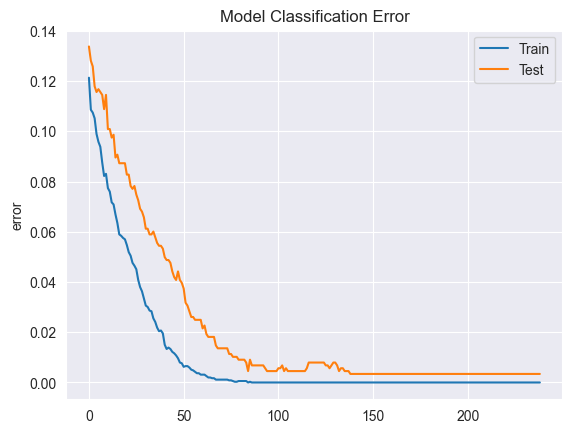

In [26]:
# Modification du type des colonnes pour que le modèle puisse se servir des "catégories"
for col in X_train.select_dtypes(include=['object']).columns:
    X_train[col] = X_train[col].astype('category')
    X_test[col] = X_test[col].astype('category')

# XGBClassifier Model

## Try except en cas d'erreur de GPU (absence de GPU ou GPU AMD)
try:
    xgb = XGBClassifier(n_estimators=1000, enable_categorical=True, tree_method="gpu_hist", early_stopping_rounds=100, learning_rate=0.15)
    eval_set = [(X_train, y_train), (X_test, y_test)]
    eval_metric = ["auc","error"]
    xgb.fit(X_train, y_train, eval_metric=eval_metric, eval_set=eval_set, verbose=True)
except:
    print("GPU Nvidia non détecté. Merci de lancer ce notebook sur un équipement possédant un GPU Nvidia récent.")

# Prédictions
xgb_pred = xgb.predict(X_train)


# Graph d'erreurs
results = xgb.evals_result()
epochs = len(results['validation_0']['error'])
x_axis = range(0, epochs)
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['error'], label='Train')
ax.plot(x_axis, results['validation_1']['error'], label='Test')
ax.legend()
plt.ylabel('error')
plt.title('Model Classification Error')
plt.show()

Vérification de la précision sur le set de train

In [27]:
accuracy_score(y_train, xgb_pred)

1.0

Le modèle peut avoir overfit. Vérifions##

## Vérification du modèle sur le set de train

Matrice de confusion

In [28]:
confusion_matrix(y_train, xgb_pred)

array([[2947,    0],
       [   0,  580]], dtype=int64)

Précision et Recall du modèle sur le set de train

In [29]:
print('Precision: %.3f' % precision_score(y_train, xgb_pred))
print('Recall: %.3f' % recall_score(y_train, xgb_pred))

Precision: 1.000
Recall: 1.000


## Vérification du modèle sur le set de test

Vérification de la précision sur le set de test

In [30]:
test_inference = xgb.predict(X_test)
accuracy_score(y_test, test_inference)

0.9965986394557823

MAE & RMSE

In [31]:
print('MAE: %.3f' % mean_absolute_error(y_test, test_inference))
print('RMSE: %.3f' % mean_squared_error(y_test, test_inference))

MAE: 0.003
RMSE: 0.003


Courbe ROC et AUC

No Skill: ROC AUC=0.500
XGB: ROC AUC=0.984


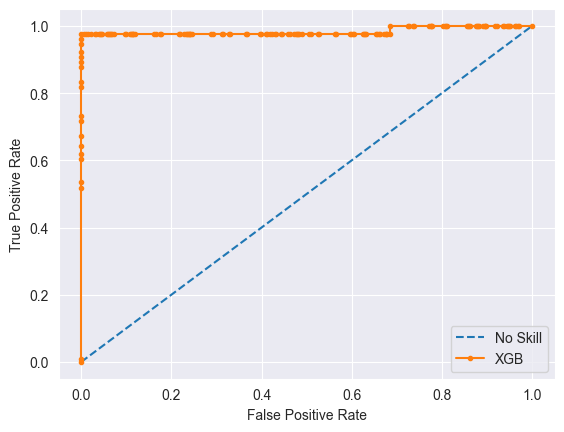

In [32]:
# generate a no skill prediction (majority class)
ns_probs = [0 for _ in range(len(y_test))]
# predict probabilities
xgb_probs = xgb.predict_proba(X_test)
# keep probabilities for the positive outcome only
xgb_probs = xgb_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
xgb_auc = roc_auc_score(y_test, xgb_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('XGB: ROC AUC=%.3f' % (xgb_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
xgb_fpr, xgb_tpr, _ = roc_curve(y_test, xgb_probs)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(xgb_fpr, xgb_tpr, marker='.', label='XGB')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

Matrice de confusion

In [33]:
confusion_matrix(y_test, test_inference)

array([[751,   0],
       [  3, 128]], dtype=int64)

F1 Score

In [ ]:
print('F1 Score: %.3f' % f1_score(y_test, test_inference))

## Conclusion

Vérification du poids de chaque feature

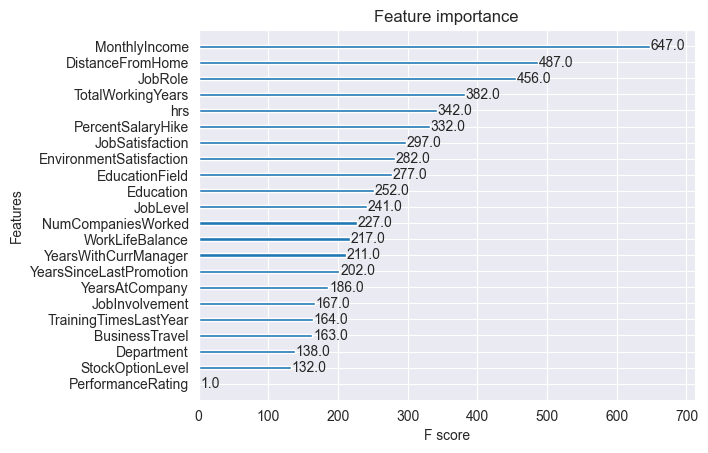

<Figure size 3200x1200 with 0 Axes>

In [34]:
plot_importance(xgb)
plt.figure(figsize = (32, 12))
plt.show()